Hello!

The purpose of this notebook is just to provide a few simple examples for what is contained within this repository.  This is not intended to be documentation, but rather just to show what exists within the background of the few code lines required to actually set up and train representation of dynamical environments.

First let's just make sure the notebook is running in the correct directory to see the source files.

In [ ]:
import os

i = 0
while ('_data' not in os.listdir()) and (i < 5):
    os.chdir("../")
    i += 1
        
print("Set cwd to :", os.getcwd())

# 1. Factorised datasets

We consider labelled datasets consisting of still images of dynamical environments.  In practice this essentailly means we have some number of generative factors, each of which can can one of several values for a given sample.  We call such datasets factorised, and all of those built in (``GridWorld``, ``Cars3D`` and ``Shapes3D``) extend the ``FactorisedDataset`` base-class and share the same basic mechanics.  This allows us to quickly switch between different datasets and, hopefully, makes it straightforward to extend this code in the future.

The ``Cars3D`` and ``Shapes3D`` datasets are publicly available (original papers can be found [here](https://papers.nips.cc/paper/5845-deep-visual-analogy-making) and [here](https://arxiv.org/abs/1802.05983), respectively).  To download them into this project (**as is requried before initialisating them**) run the relavant bash scripts found in ``scripts/download_3dxxx.sh``.

Note that basic information describing the factors and the number of values they can take for each dataset can be found from the ``FactorisedDataset.info()`` class method.  All datasets currently supported correspond to $64 \times 64$ pixels, with RGB values from 0 to 1 (i.e. each sample has dimensions $(64, 64, 3)$).  As we will see below, each dataet can be imported with only a subset of the allowed variational factors.

In [2]:
from src.factorised_datasets import GridWorld, Cars3D, Shapes3D

In [3]:
for cls in [GridWorld, Cars3D, Shapes3D]:
    print(cls.info(), "\n")

GridWorld is FactorisedDataset with 'factor name : number of allowed values':
	North-South : 1000
	East-West : 1000
	Size : 10
	Color : 5
	Background Color : 5 

Cars3D is FactorisedDataset with 'factor name : number of allowed values':
	elevation : 4
	azimuth : 23
	object : 199 

Shapes3D is FactorisedDataset with 'factor name : number of allowed values':
	floor_hue : 10
	wall_hue : 10
	object_hue : 10
	scale : 8
	shape : 4
	orientation : 15 



### ``GridWorld``

In [4]:
grid_world = GridWorld([5,5,[0],[0],[4]])

shape = grid_world.dataset.shape
print(f"{shape[0]} datapoints, each of shape {shape[1:]}.")

Intitialised dataset with following (factors : values)...
	North-South : [0, 1, 2, 3, 4]
	East-West : [0, 1, 2, 3, 4]
	Size : [0]
	Color : [0]
	Background Color : [4]
25 datapoints, each of shape (64, 64, 3).


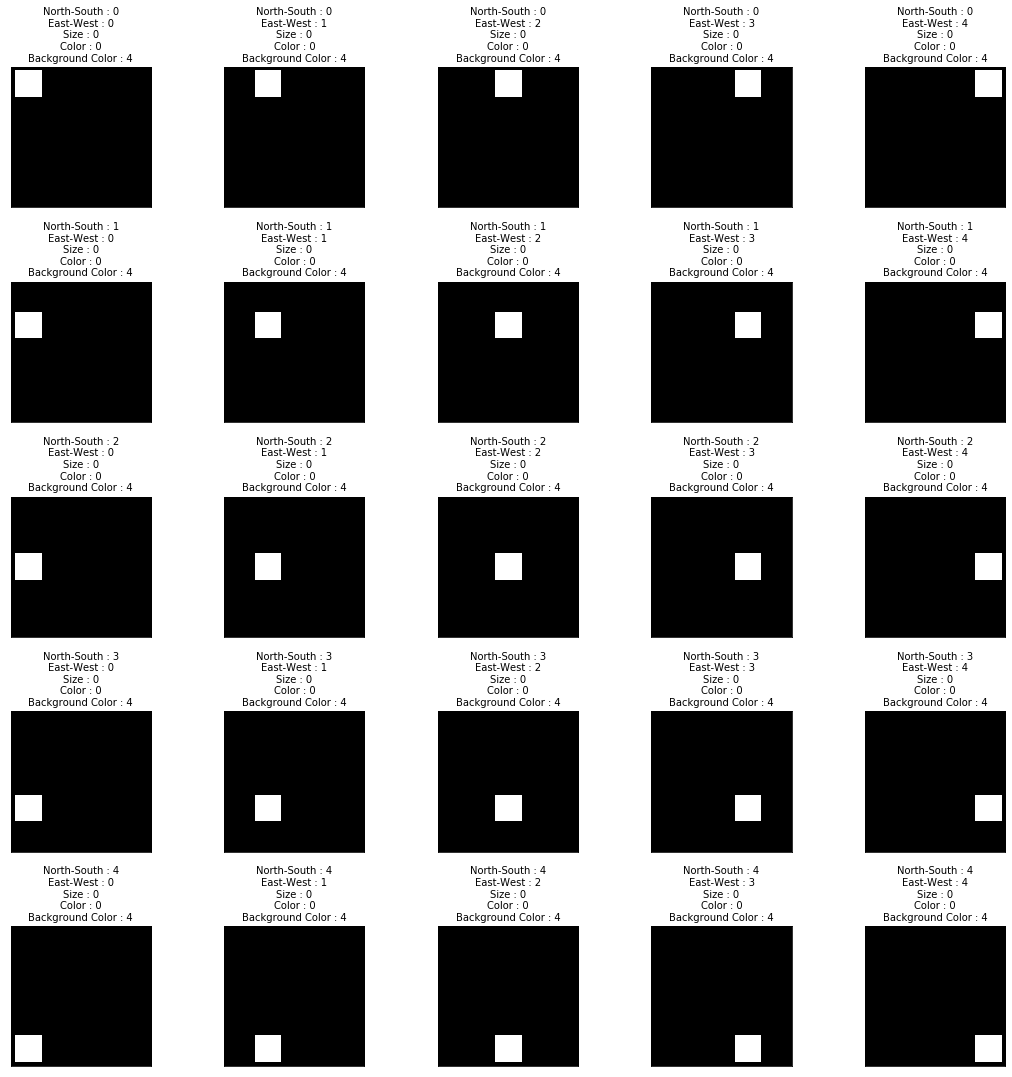

In [5]:
grid_world.imshow();

### ``Cars3D``

In [6]:
cars_3d = Cars3D([4,4,1])

shape = cars_3d.dataset.shape
print(f"{shape[0]} datapoints, each of shape {shape[1:]}.")

Intitialised dataset with following (factors : values)...
	elevation : [0, 1, 2, 3]
	azimuth : [0, 1, 2, 3]
	object : [0]
16 datapoints, each of shape (64, 64, 3).


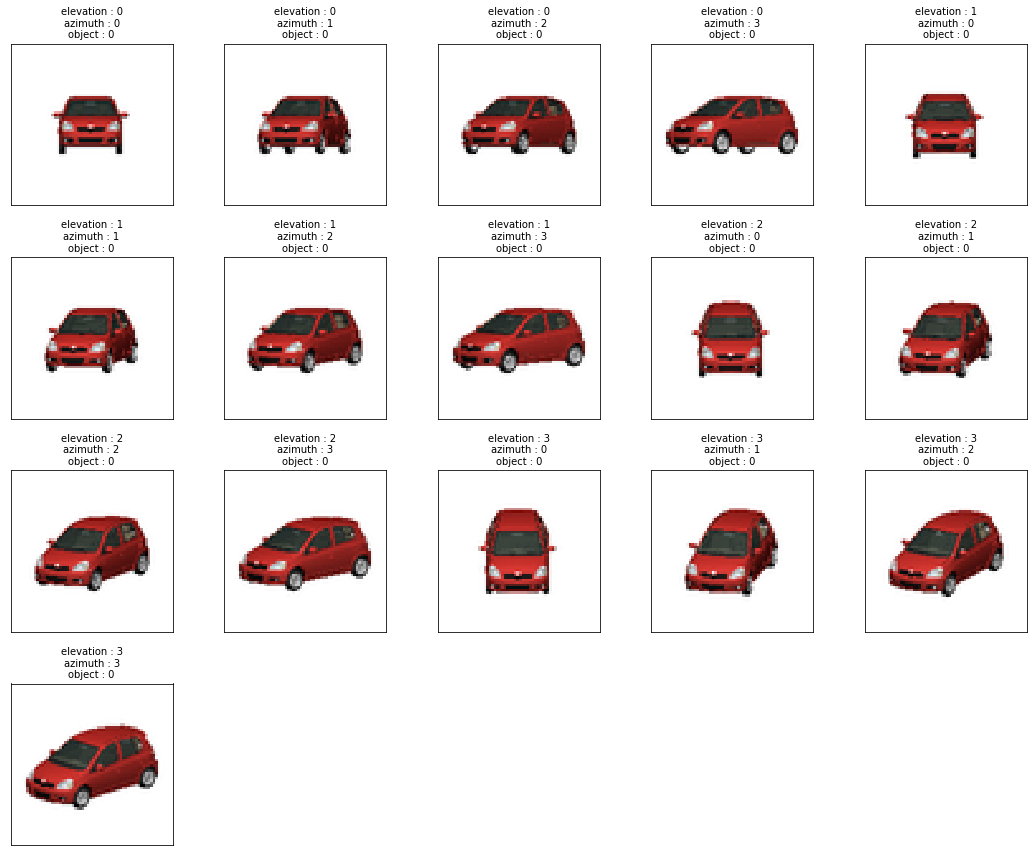

In [7]:
cars_3d.imshow();

### ``Shapes3D``

In [8]:
shapes_3d = Shapes3D([5, 5, 1, 1, 1, 1])

shape = shapes_3d.dataset.shape
print(f"{shape[0]} datapoints, each of shape {shape[1:]}.")

Intitialised dataset with following (factors : values)...
	floor_hue : [0, 1, 2, 3, 4]
	wall_hue : [0, 1, 2, 3, 4]
	object_hue : [0]
	scale : [0]
	shape : [0]
	orientation : [0]
25 datapoints, each of shape (64, 64, 3).


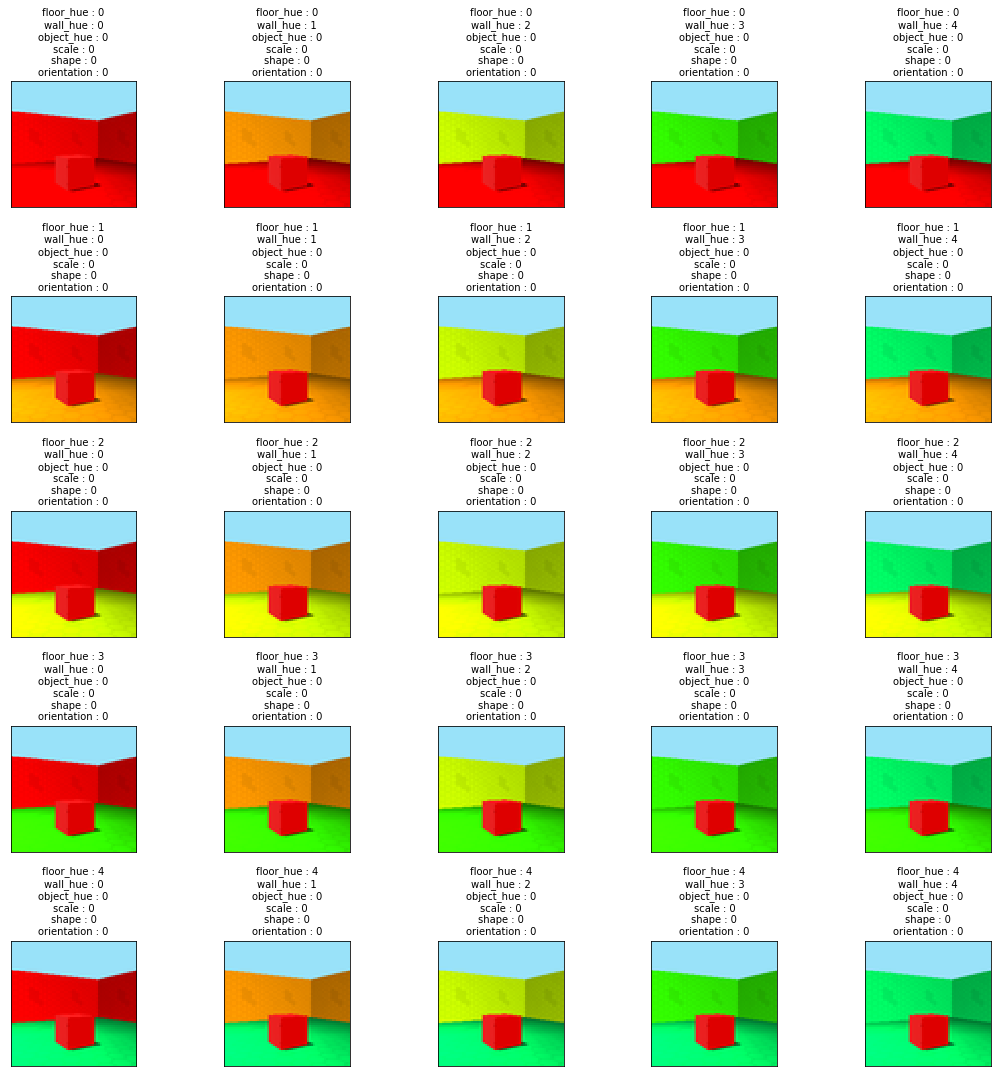

In [9]:
shapes_3d.imshow();

# 2. ``DynamicWorld`` environment

Now, we want to map these image datasets to dynamic environments.  This is environment is an $n$-dimensional grid for $n$ free generative factors, where each point corresponds to a certain set of factors.  To make this dynamical, we consider all the generative factors have set cycle and actions that correspond to stepping forward or backward in this cycle.

This is achieved by wrapping a ``FactorisedDataset`` in a ``DynamicWorld``.  The only other parameters we set for the ``DynamicWorld`` are:
- ``batch_size``: how many of these environments do we consider running in parallel, with each obervation returning a tuple ``(batch size,64,64,3)``.
- ``random_resets``: whether the environment always resets to the same set of factors, or if it starts randomly.
- ``device``: the device to which we map the dataset (i.e. PyTorch tensor of observations corresponding to each observation) -- should be ''cpu'' or ''cuda''.

Here, I'll just show how the key ways we interact with these environments:
- ``DynamicWorld.reset()``: Resets all environments in the batch.
- ``DynamicWorld.view(idx)``: Shows an image of the current state of environment ``idx``.
- ``DynamicWorld.get_observation()``: Returns the observations as a tensor for further processing.
- ``DynamicWorld.step([action_1, action_2,...])``: Takes an action to change the state of the environment(s).

Further details can be found in the code itself.

In [13]:
from src.environments import DynamicWorld

In [17]:
env = DynamicWorld(shapes_3d, batch_size=2)

At each time step we have observations as Tensors with shape:
t=0 : torch.Size([2, 64, 64, 3])
t=1 : torch.Size([2, 64, 64, 3])
t=2 : torch.Size([2, 3, 64, 64])
Notice the RGB channel is either first (t=2) or last (t=0,1) in a single image depending on the channel_last flag.


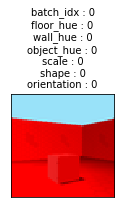

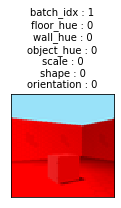

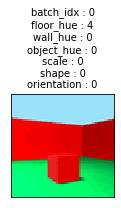

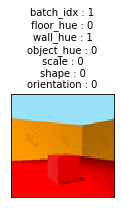

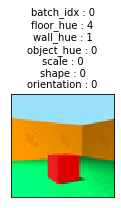

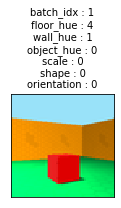

In [44]:
figs = []
obs = []

env.reset()
figs.append( [env.view(0), env.view(1)] );
obs.append(env.get_observation(channel_last=True) )
env.step([1,2])
figs.append( [env.view(0), env.view(1)] );
obs.append(env.get_observation(channel_last=True) )
env.step([2,1])
figs.append( [env.view(0), env.view(1)] );
obs.append(env.get_observation(channel_last=False) )

print("At each time step we have observations as Tensors with shape:")
for t, ten in enumerate(obs):
    print(f"t={t} : {ten.shape}")
print("Notice the RGB channel is either first (t=2) or last (t=0,1) in a single image depending on the channel_last flag.")

# 3. Spherical latent spaces

Now we want to map our dyanmical environments to a latent space, ultimately with the goal of finding a disentangled representation for both the state of the environment and the actions that evolve it.  Further details on the motivation for this, and un-packing the precise meaning of that (possibly abstract sounding) sentence can be found the the paper, ["Learning Disentangled Representations and Group Structure of Dynamical Environments"](https://arxiv.org/abs/2002.06991), for which this code was developed.

In this section we will briefly overview the ``LatentWorld`` and ``Representation`` classes that correspond to a spherical latent space and our particualr method of encoding `actions' within these spaces, respectively.

### 3.1 ``LatentWorld``

As a fan of symettry, the ``LatentWorld`` class largely behaves like the ``DynamicWorld`` class we have already seen (indeed they are both sub-classes of ``BaseWorld`` if you want to dig into the code itself).  However, it does have slightly different initialisation options, namely:
- ``dim``: The number of dimensions in which we encode the latent space (e.g. ``dim=2`` would correspond to mapping all observations to points on a circle, ``dim=3`` to points on a sphere, etc.).
- `` n_actions``: The number of allowed actions in this latent space.  Typically this would be twice the number of generative factors in the observation space, as each factor can be stepped forwards or backwards (e.g. we have a separate action for left and right corresponding to a the East-West factor in our ``GridWorld`` etc).
- ``action_reps``: By default the representations of these actions are randomly initialised, but you can pass (pre-trained presumably) representations if you want.
- ``batch_size``/``random_resets``/``device``: The same as for ``DynamicWorld``.

In [63]:
from src.environments import LatentWorld
import numpy as np

In [49]:
latent_world = LatentWorld(dim=2, n_actions=4, batch_size=2)

In [66]:
for t in range(3):
    print(f"---At t={t}--- \nobservation is :\n{latent_world.get_observation()}")
    acts = latent_world.action_space.sample(2)
    print(f"Taking actions : {acts}\n")
    latent_world.step(acts)

---At t=0--- 
observation is :
tensor([[ 0.9953, -0.0971],
        [-0.3748,  0.9271]], grad_fn=<SqueezeBackward0>)
Taking actions : tensor([3, 3])

---At t=1--- 
observation is :
tensor([[ 0.9276,  0.3735],
        [-0.7606,  0.6492]], grad_fn=<SqueezeBackward0>)
Taking actions : tensor([1, 2])

---At t=2--- 
observation is :
tensor([[ 0.1920,  0.9814],
        [-0.7226, -0.6913]], grad_fn=<SqueezeBackward0>)
Taking actions : tensor([1, 3])



### 3.2 ``Representation``

The crux of the matter is learning to 'represent' actions in the observation space with actions in latent space.  Here, we will do this by assuming every action is a generalized rotation in latent space, which we denote with a series of 2-dimensional rotations.

A 2-d rotation is given by:

\begin{pmatrix}
\cos(\theta) & \sin(\theta) \\
-\sin(\theta) & \cos(\theta)
\end{pmatrix}

and we denote a rotation in dimensions $i$ and $j$ of a higher dimensional space as $R_{i,j}(\theta)$.  For $i=1$, $j=4$, in a 4-dimensional space:

\begin{equation}
R_{1,4}(\theta) = 
\begin{pmatrix}
\cos(\theta) & 0 & 0 & \sin(\theta) \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
-\sin(\theta) & 0 & 0 & \cos(\theta)
\end{pmatrix}
\end{equation}

An arbitrary rotation, denoted $g$ as I am subtly moving towards this being a group action, can then be written as:

\begin{equation}
    g(\theta_{1,2},\theta_{1,3},\dots,\theta_{n-1,n}) = \prod_{i=1}^{n-1} \prod_{j=1+1}^{n} R_{i,j}(\theta_{i,j})
\end{equation}

which has $n(n-1)/2$ free parameters (i.e. $\theta_{i,j}$'s).

The ``Representation`` class is simply how we track these parameters and the corresponding matrices for each action.
For example, we can go and inspect the representations automatically generated when defining the ``LatentWorld`` above.

In [82]:
action_reps = latent_world.action_reps
print(f"LatentWorld has: \n\tnum_actions : {latent_world.action_space.n}\n\trepresentations: {action_reps}")

for idx, rep in enumerate(action_reps):
    print(f"\nAction rep {idx} has")
    print(f"\tthetas : {rep.thetas}")
    print(f"\tmatrix : {rep.get_matrix()}")

LatentWorld has: 
	num_actions : 4
	representations: [<src.representations.Representation object at 0x126c60110>, <src.representations.Representation object at 0x12a015a90>, <src.representations.Representation object at 0x12a856090>, <src.representations.Representation object at 0x129ff8690>]

Action rep 0 has
	thetas : tensor([0.2887], requires_grad=True)
	matrix : tensor([[ 0.9586,  0.2847],
        [-0.2847,  0.9586]], grad_fn=<CopySlices>)

Action rep 1 has
	thetas : tensor([-0.9948], requires_grad=True)
	matrix : tensor([[ 0.5446, -0.8387],
        [ 0.8387,  0.5446]], grad_fn=<CopySlices>)

Action rep 2 has
	thetas : tensor([-1.4699], requires_grad=True)
	matrix : tensor([[ 0.1008, -0.9949],
        [ 0.9949,  0.1008]], grad_fn=<CopySlices>)

Action rep 3 has
	thetas : tensor([-0.4801], requires_grad=True)
	matrix : tensor([[ 0.8870, -0.4618],
        [ 0.4618,  0.8870]], grad_fn=<CopySlices>)


# 4. Coders

We need an encoder and decoder that maps from images to our spherical latent space and visa versa.  These are neural networks and defulat implementations for both MLP's and CNN's are provided.

Here, I'll just demonstrate the CNN encoding/decoding, as this is a better choice for images anyway!  Feel free to manually change the network architecture, but the defaults are those used in the paper and tend to be a good starting point.

*Note:* It is a pain to make sure the deconvolutions (i.e. the CNN decoder) have exactly the right dimensions -- it seems to require manual tuning of the ``output_padding``.  For now, the automatic calculation still fails for some inputs, however I hope I won't be tuning the network architecture that much so for now I'll defer a more robust implemenation until if/when it is needed.

In [112]:
from src.coders.conv import EncoderConv, DecoderConv
import matplotlib.pyplot as plt

In [88]:
encoder = EncoderConv()
decoder = DecoderConv()

print("----encoder---\n\n", encoder)
print("\n\n----decoder---\n\n", encoder)

----encoder---

 EncoderConv(
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): ReLU()
    )
  )
  (fc_layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=4, bias=True)
      (1): nnNorm()
    )
  )
)


----decoder---

 EncoderConv(
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2))
      (1): ReLU

So now we-ll bring all of these together by doing the folling:
1. Initialise observation and latent environments, with the initial latent space corresponding to the true encoding of the initial observation.
2. Sample a random action in the observation state (one for each parallel episode).
3. Evolve both the observation and latent environments according to this action.
4. Decode the latent space to get the reconstructed observation having evolved in the latent space.

In [118]:
%%capture

shapes_3d = Shapes3D([5, 5, 1, 1, 1, 1])

# 1. Initialise observation and latent environments, with the initial latent space corresponding
#    to the true encoding of the initial observation.
obs_env = DynamicWorld(shapes_3d, batch_size=5)
lat_env = LatentWorld(dim=4, n_actions=obs_env.action_space.n, batch_size=5)

obs_x = obs_env.reset()
obs_z = lat_env.reset(encoder(obs_x))

# 2. Sample a random action in the observation state (one for each parallel episode).
action = obs_env.action_space.sample()

# 3. Evolve both the observation and latent environments according to this action.
obs_x = obs_env.step(action)
obs_z = lat_env.step(action)

# 4. Decode the latent space to get the reconstructed observation having evolved in the latent space.
rec_x = decoder(obs_z)

Ground truth (top) and reconstruction (bottom) of parallel episode 0


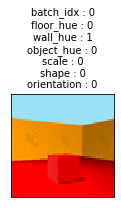

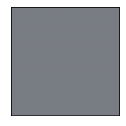

In [124]:
idx=0

print(f"Ground truth (top) and reconstruction (bottom) of parallel episode {idx}")
obs_env.view(idx);

fig = plt.figure(frameon=True, figsize=(2,2))
plt.imshow(rec_x[idx].detach().permute(1,2,0))
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
for pos in ['bottom', 'top', 'right', 'left']:
    ax.spines[pos].set_color('0')

# 5. Learning (distentangled) representations

At this point we have everything needed to actually go and learn *good* representations.  It is straightforward to compute the reconstruction loss by comparision to the ground truth images (i.e. comparing the two output impages in the previous cell).

### 5.1 Brief overview of disentanglement

However, we are particularly interested in enforcing the learnt representations to be disentangled.

***Some jargon***

Before considering how best to do this, we want to define a metric of 'disentanglement'.  We consider the evolution of an observable (latent) vector, $x \in X$ ($z \in Z$), under the element $g \in G$ of the group of symmetries generating transformations of the object.  Then we are looking for a representation, $\rho:G \rightarrow GL(V)$, such that the transformation is linear in the latent space, i.e.
\begin{equation}
    z^{\prime} = \rho(g) \cdot z.
\end{equation}
Note, in our case, the representations are the rotation matrices we learn.

For this representation to be disentangled, it means that if there exists a subgroup decomposition of $G$
\begin{equation}
    G = G_1 \times G_2 \times \dots \times G_n,
\end{equation}
then we equivalently decompose the representation, $(\rho, G)$, into subrepresentations:
\begin{equation}
    V = V_1 \oplus V_2 \oplus \dots \oplus V_n
\end{equation}
such that the restricted subrepresentations $(\rho_{\vert G_i}, V_i)_i$ are non-trivial, and the restricted subrepresentations $(\rho_{\vert G_i}, V_j)_{j \neq i}$ are trivial.

In our context, a GridWorld with 5 points in each dimension is represented by $G = C_5 \times C_5$ (where $C_5$ is the cyclic group).  This is a subgroup of $\mathrm{SO}(2) \times \mathrm{SO}(2)$, therefore we hope to find the disentangled representation of the actions (up, down, left, right) that corresponds to this.

***Entanglement regularisation***

Our intuition is that the disentangled representation acts as the identity on as many dimensions as possible.  We could attempt to enforce this with some regularization during training.  Normal weight decay won't cut it, as that tries to reduce all weights, where as what we really want to do is have all *but one* of our thetas (which corresponds to the rotation/coupling of two dimensions) to be zero.

So for $m$ parameters, ${\theta_1, \dots, \theta_m}$, we want to regularise with
\begin{equation}
    \sum_{i \neq j} \vert\theta_i\vert^2, \mathrm{where\ } \theta_j {=} \mathrm{max_k}({\vert\theta_k\vert}).
\end{equation}
We will also use this term as our metric of 'entanglement'.

### 5.2 ``DynamicRepresentationLearner``

Finally then, we bundle up everything we have seen so far into a single ``DynamicRepresentationLearner`` object, that takes a factorised dataset, some arguments describing the desired latent environment and encoder/decoder networks, and the desired entanglement regularisation, to train the corresponding system.  A few helper functions are also built in to plot and test the training and resulting representation.

Specific details can be found in the documentation, and a second notebook is provided for creating/training representations either locally or on Colab (``representation-learning.ipybn``).  Here, I'll just create a learner for a 3DShapes dataset, take 10 steps of SGD (corresponding to the reconstruction loss accumulated over 3 parallel episodes of 20 steps) and plot the results.  Of course, the results will be terrible as 10 steps is not going to learn very much!

In [128]:
from src.learners import DynamicRepresentationLearner, LossTarget

In [129]:
rep_learner = DynamicRepresentationLearner(shapes_3d,
                                           latent_dim=4,
                                           episode_length = 20,
                                           num_parallel_episodes = 3,
                                           
                                           lr_enc=5e-3,
                                           lr_dec=5e-3,
                                           lr_rep=5e-3,
                                           
                                           ent_loss_weight = 0,
                                           final_ent_loss_weight = 1e-5,
                                           final_ent_loss_weight_iter=5000,
                                           ent_loss_target=LossTarget.MIN,
                                           random_resets=False,

                                           save_loc="_results/my_test_run")

In [130]:
rep_learner.train(num_sgd_steps=10,log_freq=1)

iter 1 : loss=0.69461 : recon. loss : 0.69461 : ent. loss : 0.54017 : last 1 iters in 0.294s
iter 2 : loss=0.68907 : recon. loss : 0.68907 : ent. loss : 0.53903 : last 1 iters in 0.272s
iter 3 : loss=0.68292 : recon. loss : 0.68292 : ent. loss : 0.53726 : last 1 iters in 0.266s
iter 4 : loss=0.66115 : recon. loss : 0.66115 : ent. loss : 0.53727 : last 1 iters in 0.261s
iter 5 : loss=0.64809 : recon. loss : 0.64809 : ent. loss : 0.53844 : last 1 iters in 0.273s
iter 6 : loss=0.65309 : recon. loss : 0.65309 : ent. loss : 0.54115 : last 1 iters in 0.252s
iter 7 : loss=0.62125 : recon. loss : 0.62125 : ent. loss : 0.54353 : last 1 iters in 0.273s
iter 8 : loss=0.61346 : recon. loss : 0.61346 : ent. loss : 0.54493 : last 1 iters in 0.262s
iter 9 : loss=0.61913 : recon. loss : 0.61913 : ent. loss : 0.54710 : last 1 iters in 0.251s
iter 10 : loss=0.58267 : recon. loss : 0.58267 : ent. loss : 0.54859 : last 1 iters in 0.264s


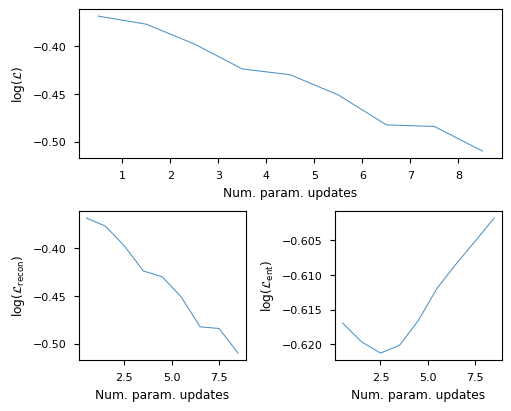

In [131]:
rep_learner.plot_training(save=False);

/Users/tombarrett/PycharmProjects/Published/dynamical-disentanglement/src/learners.py:598: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/tombarrett/PycharmProjects/Published/dynamical-disentanglement/src/learners.py:529: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4, h), constrained_layout=True)


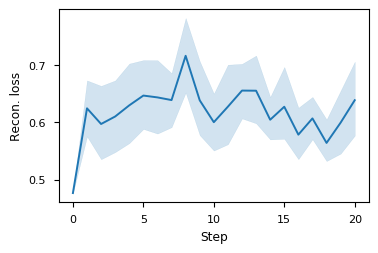

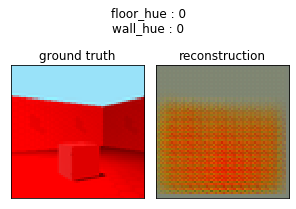

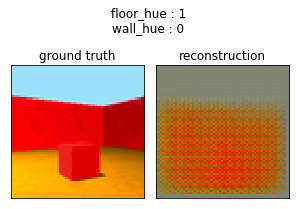

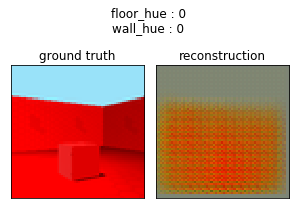

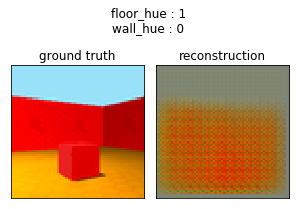

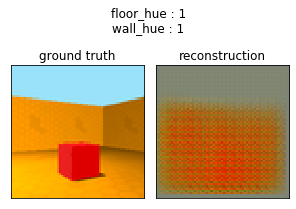

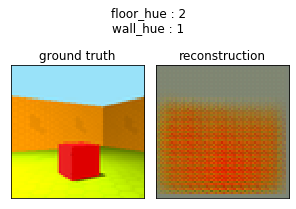

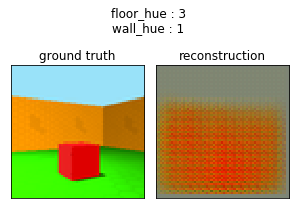

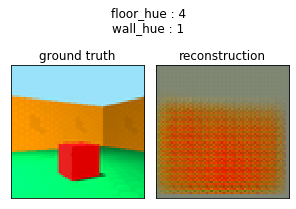

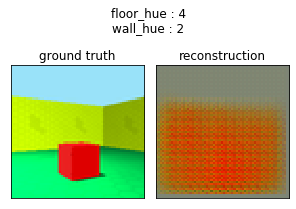

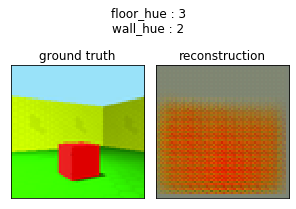

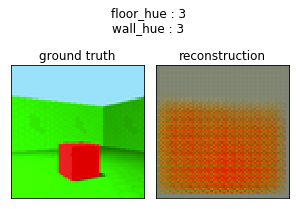

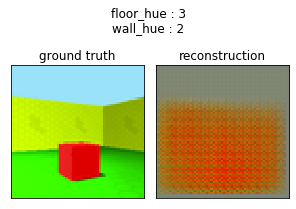

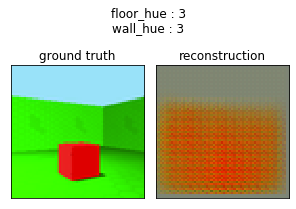

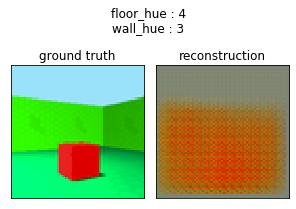

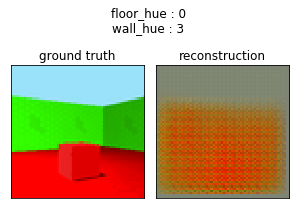

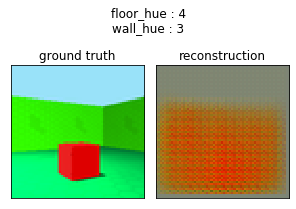

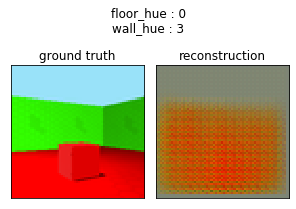

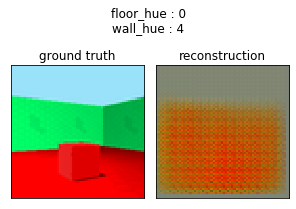

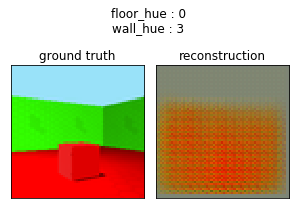

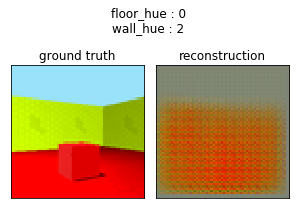

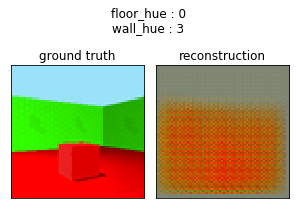

In [132]:
rep_learner.test(episode_length=20,
                 num_episodes=10,
                 save_scores=False, # Save pd.Dataframe of scores from each episode.
                 save_plot=False, # Save plot of scores from each episode.
                 show_imgs=True, # Show ground truth and reconstructed images (from only a single episode).
                 save_imgs=False) # Save ground truth and reconstructed images (from all episodes)

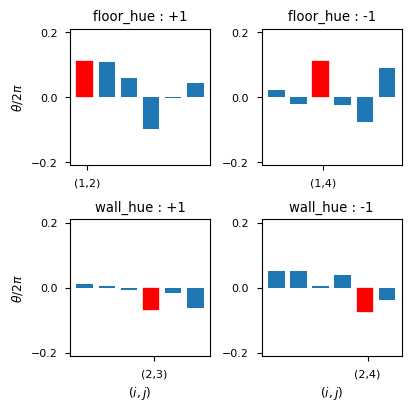

In [133]:
rep_learner.plot_representations(save=False, num_highlight=1);